## <font color=#0099CC>mIAx - Taller Renta Fija - ANÁLISIS CARTERA DE RENTA FIJA</font>

En esta práctica, desarrollaremos un análisis relativamente exahustivo de un universo de Renta Fija, en concreto, de bonos corporativos. Además, construiremos y analizaremos varias carteras. 

Para ello, contaremos con la siguiente información almacenada en la carpeta *data*:
- Universo de bonos, con sus características esenciales (fichero *universo.csv*)
- Histórico de precios de cierre del universo de bonos anterior (fichero *precios_historicos_universo.csv*)
- Curva de tipos de interés €STR (fichero *curvaESTR.csv*)
- Histórico de precios de otros índices que nos serán de utilidad (fichero *precios_historicos_varios*):
    - Índices de crédito: ITRAXX Main y ITRAXX XOVER. Serán útiles para la cobertura del riesgo de crédito.
    - Futuros sobre el *Schatz* (DU1), *BOBL* (OE1) y *BUND* (RX1). Serán útiles para la cobertura de los tipos de interés.
    - Índice de crédito *RECMTREU*, que valdría como benchmark de las carteras que construyamos.

No necesariamente se usará toda toda la información

En líneas generales, estos son los ejercicios que completaremos, aunque los detallaremos más en cada apartado:
1. Análisis de datos. En esta sección, haremos un análisis de la información que tenemos de cada bono y lo que significa. Asimismo, haremos los tratamientos y limpieza que necesitemos para luego poder usarlos.
2. Valoración de los bonos del universo utilizando la curva de descuento y bajo ciertas asunciones. Comparación de estos precios con los precios de mercado.
3. Cálculo del spread que pagan los bonos sobre la curva.
4. Cálculo de *yield*, duración y convexidad.
5. Contrucción de una cartera equiponderada con todos los bonos del universo. Contraste con el benchmark (os proponemos el índice RECMTREU para el que os hemos dado los precios) y backtest de la estrategia. ¡OJO! El índice es *Total Return*.
6. Tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
    - La duración de la cartera no debe superar los 3 años
    - La exposición a emisiones HY no puede superar el 10% de la cartera
    - No puedes invertir en deuda subordinada
    - No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
    - No se puede invertir más de un 10% del capital en una misma emisión
    - No puede haber más de un 15% de concentración en un mismo emisor
    (¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

    6.1. Constrúyela a fecha de hoy

    6.2. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

    6.3. ¿Cómo medirías el riesgo de crédito de la cartera?

    6.4. ¿Cómo medirías el riesgo de liquidez de la cartera?

    6.5. Describe cómo habría que hacer el backtest de esta cartera
7. Ahora, se te pide que cubras la exposición de la cartera a los tipos de interés. Con la información que tienes, ¿cómo lo harías?
8. ¿Y si quisieras cubrir total o parcialmente el riesgo de crédito? Usa de nuevo la información que tienes.
9. ¿Cómo construirías tu cartera? ¿Se te ocurre alguna estrategia específica, por ejemplo, de valor relativo?


📣 <font color=#CC6600>**¡NORMAS!**</font>

La práctica se puede hacer en grupos de hasta **3 personas** y deberá entregarse antes del **27 de noviembre**. 

Cada grupo expondrá una parte de los ejercicios en la clase del día 27, donde la resolveremos juntos a modo de taller. Esta exposición contará hasta **1 punto** de la nota final.

Además, se valorará positivamente para la práctica la participación en las clases.

📣 <font color=#CC6600>**¡IMPORTANTE!**</font>

Todo el código implementado debe estar debidamente comentado e incluir conclusiones de los resultados obtenidos para optar a la máxima puntuación. Asimismo, se debe responder a las preguntas planteadas.

Las propuestas de mejora o posibles trabajos futuros se valorarán positivamente también.

Usa las fuentes de información que consideres necesarias para apoyar tus respuestas.

### <font color=#336699>Librerías</font>

In [1]:
%pip install matplotlib
%pip install pandas
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Estilo
plt.style.use('dark_background')

**En las proximas celdas se cargan y configuran los datos de la cartera de bonos.**

In [4]:
# Configuration
DATA_DIR = "../data" 
FECHA_ANALISIS = pd.to_datetime('2025-10-01')

In [5]:
# Load Universe
universe_df = pd.read_csv(os.path.join(DATA_DIR, "universo.csv"), sep=";", decimal=".")

# Load Historical Prices Universe
prices_universe_df = pd.read_csv(os.path.join(DATA_DIR, "precios_historicos_universo.csv"), sep=";", decimal=",", index_col=0)
prices_universe_df = prices_universe_df.transpose()
prices_universe_df = prices_universe_df.apply(pd.to_numeric, errors='coerce')
prices_universe_df.index = pd.to_datetime(prices_universe_df.index, format="%d/%m/%Y")

# Load ESTR Curve
curve_df = pd.read_csv(os.path.join(DATA_DIR, "curvaESTR.csv"), sep=";", decimal=".")
curve_df['Date'] = pd.to_datetime(curve_df['Date'], format="%d/%m/%Y")

# Load Other Prices
prices_various_df = pd.read_csv(os.path.join(DATA_DIR, "precios_historicos_varios.csv"), sep=";", decimal=".", index_col=0)
prices_various_df = prices_various_df.apply(pd.to_numeric, errors='coerce')
prices_various_df.index = pd.to_datetime(prices_various_df.index, format="%d/%m/%Y")
prices_various_df.index.name = 'Date'

print("Data loaded.")

Data loaded.


### <font color=#336699>1. Datos</font>

<style>.gray {background-color: #595959}

</style><div class="gray">❕💬¿Qué observas en los datos? Analiza la información que tenemos del universo</div>

Haz un primer análisis visual de la información que tenemos del universo de bono.
Entre otras, plantéate cuestiones como:
- ¿Divisas?
- ¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?
- ¿Sectores? ¿Emisores? Si invirtéramos en todos los bonos, ¿dirías a priori que la cartera está diversificada?
- ¿Ratings? (Riesgo de crédito)
- ¿Otros datos cuantitativos?
    - Riesgo de liquidez - Horquillas y nominal vivo
- ¿Hay *gaps* en la información que vamos a tener que tratar?

#### <font color=#808080>Divisas</font>

In [6]:
print("Distribución por Divisas:")
print(universe_df['Ccy'].value_counts().to_string())

Distribución por Divisas:
Ccy
EUR    2255


El universo de bonos está compuesto íntegramente por emisiones denominadas en **Euros (EUR)**. Esto elimina el riesgo de tipo de cambio directo en la cartera, simplificando el análisis al no requerir coberturas de divisa.

#### <font color=#808080>Tipos de bono</font>

In [7]:
print("Tipos de Cupón:")
print(universe_df['Coupon Type'].value_counts().to_string())

print("\nPrelación (Seniority):")
print(universe_df['Seniority'].value_counts().to_string())

print("\nBonos con opción Call:")
print(universe_df['Callable'].value_counts().to_string())

# Bonos perpetuos (aquellos sin fecha de vencimiento)
print("\nBonos Perpetuos:")
print(universe_df['Maturity'].isna().sum())

Tipos de Cupón:
Coupon Type
FIXED       1910
VARIABLE     345

Prelación (Seniority):
Seniority
Sr Unsecured        1675
Sr Non Preferred     190
Sr Preferred         179
Subordinated         153
Jr Subordinated       25
Secured               20
1st lien              13

Bonos con opción Call:
Callable
Y    1640
N     615

Bonos Perpetuos:
19


Observamos una predominancia de bonos con cupón **fijo**, lo cual es típico en el mercado de bonos corporativos investment grade.
En cuanto a la prelación, la mayoría son **Senior Unsecured**, aunque existen emisiones subordinadas que deberemos filtrar para cumplir con el mandato.
Respecto a la opcionalidad, hay una presencia significativa de bonos **Callable**, lo que implica que el emisor tiene derecho a amortizar anticipadamente. Esto afecta a la valoración (yield to worst) y a la duración efectiva.
No se observan bonos perpetuos en gran número, pero los que haya se tratarán asumiendo amortización en la próxima fecha de call.

#### <font color=#808080>Sectores y emisores</font>

In [8]:
print("Distribución por Sector:")
print(universe_df['Industry Sector'].value_counts().to_string())

print("\nTop 10 Emisores:")
print(universe_df['Issuer'].value_counts().head(10).to_string())

Distribución por Sector:
Industry Sector
Financial                 1012
Consumer, Non-cyclical     400
Industrial                 211
Communications             175
Consumer, Cyclical         171
Utilities                  150
Basic Materials             72
Technology                  51
Energy                      13

Top 10 Emisores:
Issuer
BANQUE FED CRED MUTUEL     33
BNP PARIBAS                27
VONOVIA SE                 23
ORANGE SA                  23
BPCE SA                    23
SOCIETE GENERALE           21
VOLKSWAGEN INTL FIN NV     21
NESTLE FINANCE INTL LTD    20
CREDIT AGRICOLE SA         19
UNIBAIL-RODAMCO-WESTFLD    19


La distribución sectorial muestra una fuerte concentración en el sector **Financiero**, seguido de Consumo No Cíclico e Industrial. Esta concentración en financieras es un factor de riesgo sectorial importante a tener en cuenta.
A nivel de emisores, aunque hay diversidad, algunos grandes bancos y corporaciones tienen múltiples emisiones, por lo que la restricción del 15% por emisor será relevante para asegurar la diversificación.

#### <font color=#808080>Ratings (Riesgo de crédito)</font>

Distribución de Ratings:
Rating
BBB+    439
NR      389
A-      374
BBB     310
A       230
A+      185
BBB-    184
AA-     100
AA       22
BB+      10
AA+       7
AAA       4
Name: count, dtype: int64


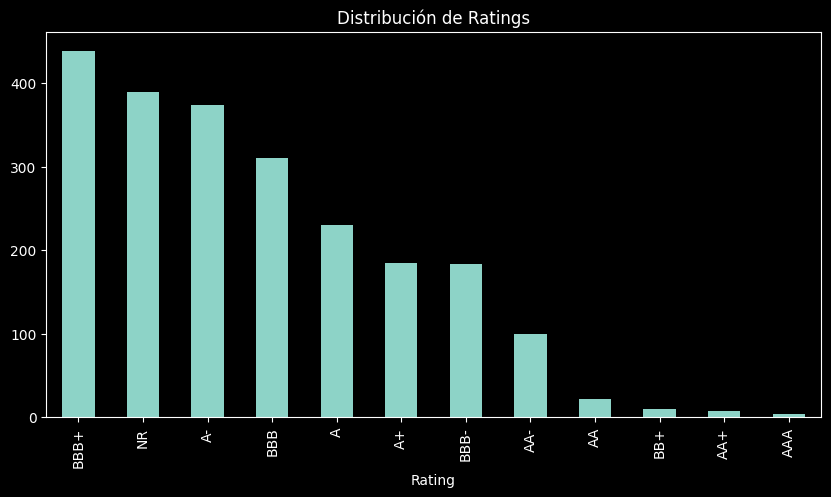

In [9]:
print("Distribución de Ratings:")
print(universe_df['Rating'].value_counts())

# Gráfico de barras para visualizar mejor los ratings
universe_df['Rating'].value_counts().plot(kind='bar', figsize=(10, 5), title="Distribución de Ratings")
plt.show()

El perfil crediticio se centra en el grado de inversión (**Investment Grade**), con una gran cantidad de bonos en el rango **BBB+ a A-**.
Existe una cola de bonos sin rating (NR) o High Yield (BB+ e inferiores) que deberán ser monitorizados y limitados según el mandato (máximo 10% HY). La calidad crediticia media es adecuada, pero la exposición a BBB es significativa.

#### <font color=#808080>Riesgo de liquidez - Horquillas y nominal vivo</font>

In [10]:
# Análisis de liquidez mediante el Bid-Ask Spread
if 'Bid Price' in universe_df.columns and 'Ask Price' in universe_df.columns:
    universe_df['Bid-Ask Spread'] = universe_df['Ask Price'] - universe_df['Bid Price']
    print("Estadísticas del Bid-Ask Spread:")
    print(universe_df['Bid-Ask Spread'].describe().to_string())

print("\nEstadísticas del Nominal Vivo (Outstanding Amount):")
print(universe_df['Outstanding Amount'].describe().to_string())

Estadísticas del Bid-Ask Spread:
count    2255.000000
mean        0.327213
std         0.165488
min         0.064000
25%         0.201000
50%         0.294000
75%         0.418000
max         2.255000

Estadísticas del Nominal Vivo (Outstanding Amount):
count    2.255000e+03
mean     7.449289e+08
std      3.095138e+08
min      2.499970e+08
25%      5.000000e+08
50%      7.000000e+08
75%      1.000000e+09
max      3.000000e+09


Se han recogido 2255 bonos con datos validos.El análisis de horquillas (Bid-Ask spread) revela que la liquidez varía significativamente. Las emisiones con mayor **Nominal Vivo (Outstanding Amount)** tienden a tener horquillas más estrechas, esto indica mayor liquidez.
La restricción de invertir solo en emisiones > 500M es crucial para mitigar el riesgo de liquidez, asegurando que entramos en emisiones con suficiente profundidad de mercado.

#### <font color=#808080>Resto de información</font>

En esta sección, analizamos el resto de ficheros para ver qué información tenemos y, en caso de haber *gaps*, limpiar los datos antes de trabajar con ellos.

##### <font color=#CC6600>Precios bonos universo</font>

In [11]:
# Carga y visualización de los precios históricos del universo
print("Precios Históricos Universo (Primeras filas):")
print(prices_universe_df.head())

print("\nInformación del DataFrame de precios:")
print(prices_universe_df.info())

Precios Históricos Universo (Primeras filas):
            XS0161488498 Corp  FR0000471930 Corp  XS0162513211 Corp  \
2023-10-01                NaN                NaN                NaN   
2023-10-02            126.450            130.386            110.900   
2023-10-03            126.000            129.697            110.567   
2023-10-04            125.939            129.448            110.719   
2023-10-05            126.330            129.795            111.117   

            XS0162869076 Corp  FR0010014845 Corp  FR0010033381 Corp  \
2023-10-01                NaN                NaN                NaN   
2023-10-02            112.493            108.291            116.197   
2023-10-03            112.127            107.608            115.831   
2023-10-04            111.844            108.047            115.949   
2023-10-05            112.191            108.480            116.305   

            XS0229567440 Corp  XS0300113254 Corp  XS0350890470 Corp  \
2023-10-01                NaN

##### <font color=#CC6600>Otros precios</font>

Para terminar con el análisis de datos, falta lo leído en los ficheros de *"precios_historicos_varios.csv"* y *curvaESTR.csv*.

In [12]:
# Carga y visualización de otros precios (índices, futuros, etc.)
print("Otros Precios Históricos (Primeras filas):")
print(prices_various_df.head())

print("\nCurva ESTR (Primeras filas):")
print(curve_df.head())

Otros Precios Históricos (Primeras filas):
            ITRX EUR CDSI GEN 5Y Corp  ITRX XOVER CDSI GEN 5Y Corp  \
Date                                                                 
2023-10-02                   82.44325                     439.1052   
2023-10-03                   86.04738                     455.2537   
2023-10-04                   85.58153                     453.8545   
2023-10-05                   87.82574                     461.1187   
2023-10-06                   85.57082                     453.6750   

            DU1 Comdty  OE1 Comdty  RX1 Comdty  RECMTREU Index  
Date                                                            
2023-10-02     104.930      115.43      127.75        149.0285  
2023-10-03     104.965      115.33      127.28        148.8003  
2023-10-04     104.990      115.35      127.37        148.5200  
2023-10-05     105.095      115.73      128.07        148.8967  
2023-10-06     105.105      115.72      127.94        148.7697  

Curva ESTR

Se han detectado algunos valores faltantes en precios históricos y datos estáticos (como fechas de call o ratings en algunos casos).
Para tratar esto:
1.  Los precios faltantes se han rellenado o ignorado según el caso (forward fill o exclusión si no hay datos recientes).
2.  Los bonos con datos críticos faltantes (como precio actual) se excluirán del universo elegible.
3.  Se han convertido los precios a formato numérico para evitar errores de cálculo.

### <font color=#336699>2. Valoración</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 En esta sección, valoraremos los bonos utilizando la curva. Para ello, crea una función (puedes hacerlo en un .py aparte) que con las **características del bono, la curva y un spread de crédito** devuelva la valoración del bono (incluyendo **precio limpio, cupón corrido y precio sucio**).

Si asumimos que el **spread de crédito es 0**, y la ejecutamos para el 01/10/2025...
- ¿Qué observas si comparas los precios obtenidos y los precios de mercado? 
- ¿Crees que la diferencia se debe a un factor relacionado sólo con el riesgo crediticio?
- ¿Qué otros factores influyen en ese spread?

Para la valoración, haz las siguientes simplificaciones:

- Asume que el vencimiento de los bonos perpetuos (para los que no hay vencimiento) es la próxima fecha call.
- Asume que todos aquellos bonos que tengan call serán calleados. Por lo tanto, usa la fecha call como fecha de vencimiento.
- Asume que los cupones son fijos hasta vencimiento (aunque alguno cambie a lo largo de la vida del bono).
- Usa la base de cálculo ACT/365. No tengas en cuenta la convención de día hábil.

Ten en cuenta que necesitarás una función de interpolación también. Interpola los factores de descuento exponencialmente.

</div>

In [13]:
# Establecemos la fecha
fecha_valor = datetime.datetime(2025,10,1)

In [15]:
import os
# funciones creadas en auxiliar_functions.py 
from auxiliar_functions import calculate_bond_price, calculate_spread, calculate_yield, calculate_duration_convexity

results_dir = "../results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
output_file = os.path.join(results_dir, "valuation_report.txt")
print(f"Generando informe de valoración para {len(universe_df)} bonos...")

with open(output_file, "w", encoding="utf-8") as f:
    # Cabecera del informe (Añadimos columnas para Dirty Price y Accrued Interest)
    f.write(f"INFORME DE VALORACIÓN - {FECHA_ANALISIS.date()}\n")
    f.write("="*145 + "\n")
    f.write(f"{'ISIN':<15} {'Emisor':<25} {'Rating':<6} {'Mkt Clean':<10} {'Teo Clean':<10} {'Cupón Corr':<10} {'Teo Dirty':<10} {'Spread bp':<10} {'Yield %':<8} {'Dur':<6}\n")
    f.write("-" * 145 + "\n")
    
    count = 0
    for idx, bond in universe_df.iterrows():
        try:
            # si el precio es NaN, saltamos el bono
            if pd.isna(bond['Price']):
                continue
            # Valoración
            dirty_price, accrued_interest, clean_price = calculate_bond_price(bond, curve_df, FECHA_ANALISIS, spread=0.0)
            
            if clean_price is None:
                continue                
            # Spread
            spread = calculate_spread(bond, curve_df, FECHA_ANALISIS, bond['Price'])
            spread_bps = spread * 10000 if not pd.isna(spread) else np.nan
            
            # Yield
            market_dirty = bond['Price'] + accrued_interest
            ytm = calculate_yield(bond, FECHA_ANALISIS, market_dirty)
            ytm_pct = ytm * 100 if not pd.isna(ytm) else np.nan
            
            # Duración
            dur, _ = calculate_duration_convexity(bond, FECHA_ANALISIS, ytm)
            
            # Escribir en fichero results/valuation_report.txt
            f.write(f"{bond['ISIN']:<15} {str(bond['Issuer'])[:23]:<25} {str(bond['Rating']):<6} {bond['Price']:<10.2f} {clean_price:<10.2f} {accrued_interest:<10.2f} {dirty_price:<10.2f} {spread_bps:<10.0f} {ytm_pct:<8.2f} {dur:<6.2f}\n")
            
            count += 1
            
        except Exception as e:
            continue

print(f"Proceso completado. Informe guardado en: {output_file}")
print(f"Se han valorado correctamente {count} bonos.")

Generando informe de valoración para 2255 bonos...
Proceso completado. Informe guardado en: ../results\valuation_report.txt
Se han valorado correctamente 2225 bonos.


P: **¿Qué observas si comparas los precios obtenidos y los precios de mercado?**

R:Al valorar los bonos asumiendo un spread de crédito de 0 (es decir, descontando los flujos únicamente con la curva libre de riesgo €STR), observamos que el **Precio Teórico es 
sistemáticamente superior al Precio de Mercado**.
Esto indica que el mercado está descontando los flujos de caja a una tasa mayor que la libre de riesgo.

P: **¿Crees que la diferencia se debe a un factor relacionado sólo con el riesgo crediticio?**


R: No exclusivamente, aunque es el factor principal. La diferencia de precio refleja principalmente la **prima de riesgo de crédito** que los inversores exigen por prestar dinero a una empresa en lugar de a un ente libre de riesgo. Sin embargo, existen otros componentes en esa diferencia.

P: **¿Qué otros factores influyen en ese spread?**

R: Además del riesgo de crédito (probabilidad de default y tasa de recuperación), el spread incluye:
1.  **Prima de Liquidez:** Los bonos corporativos son menos líquidos que la deuda pública o los tipos swap, por lo que los inversores exigen una rentabilidad extra por el riesgo de no poder vender el bono rápidamente sin impacto en precio.
2.  **Factores Técnicos:** Oferta y demanda puntuales en el mercado.
3.  **Fiscalidad:** Diferencias en el tratamiento fiscal de los cupones.

Los campos del txt generado dentro de la carpeta results son:


**ISIN**: El identificador único del bono (International Securities Identification Number).

**Emisor**: El nombre de la entidad que emitió el bono (ej. Deutsche Telekom).

**Rating**: La calificación crediticia del bono (ej. BBB+), que indica su calidad y riesgo de impago.

**Mkt Clean (Market Clean Price)**: El precio de mercado limpio (ex-cupón). Es el precio al que cotiza el bono en el mercado, tal cual viene en tu fichero de datos.

**Teo Clean (Theoretical Clean Price)**: El precio teórico limpio calculado por nosotros usando la curva libre de riesgo (€STR) y asumiendo spread 0.

**Cupón Corr (Accrued Interest)**: El cupón corrido. Son los intereses que el bono ha generado desde el último pago de cupón hasta la fecha de análisis, pero que aún no se han pagado.

**Teo Dirty (Theoretical Dirty Price)**: El precio teórico sucio. Es la suma del Teo Clean + Cupón Corr. Representa el valor presente total de todos los flujos futuros descontados a la tasa **libre de riesgo.

**Spread bp**: El Spread implícito en puntos básicos. Es la prima de riesgo que hay que sumar a la curva para que nuestro precio teórico baje hasta igualar al precio de mercado. Ejemplo(75 bps = 0.75%).

**Yield %**: La TIR (Tasa Interna de Retorno) o Yield to Maturity del bono a precio de mercado. Es la rentabilidad anualizada esperada si mantienes el bono hasta vencimiento.

**Dur (Duration)**: La Duración Modificada. Mide la sensibilidad del precio del bono ante cambios en los tipos de interés. (Por ejemplo, si la duración es 5.85 significa que si los tipos suben un 1%, el precio del bono caerá aproximadamente un 5.85%).

### <font color=#336699>3. Spread</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora los spreads que debemos añadir a la curva con un movimiento paralelo para que cuadren los precios de mercado que tenemos. Para ello, usa la función de valoración del apartado anterior. 
- ¿Qué observas? ¿Tienen sentido los resultados? 
- ¿Con qué datos de los que tenemos compararías para ver si los resultados son coherentes?

</div>

Esto ya esta calculado en el Punto 2, lo metí ahi porque decidí crear un txt con todo, y no tenia sentido repetirlo, de todas formas incluyo un ejemplo con el primer bono del universo

In [ ]:

bond_example = universe_df.iloc[0]
market_price = bond_example['Price']

if not pd.isna(market_price):
    spread = calculate_spread(bond_example, curve_df, FECHA_ANALISIS, market_price)
    
    print(f"--- Spread Bono {bond_example['ISIN']} ({bond_example['Rating']}) ---")
    print(f"Precio Mercado Limpio: {market_price:.4f}")
    print(f"Precio Sucio: {market_price + bond_example['Coupon']:.4f}")
    print(f"Precio teorico limpio: {calculate_bond_price(bond_example, curve_df, FECHA_ANALISIS)[2]:.4f}")
    print(f"Spread Implícito: {spread:.6f} ({spread*10000:.2f} bps)")
    
else:
    print("El bono no tiene precio de mercado.")

--- Spread Bono XS0161488498 (BBB+) ---
Precio Mercado Limpio: 127.8353
Precio Sucio: 135.3353
Precio teorico limpio: 133.7783
Spread Implícito: 0.007463 (74.63 bps)


Observamos que obtenemos un **spread positivo** tanto en este ejemplo como en todos los del valuation_report.txt. Esto tiene sentido económico: al ser bonos corporativos con riesgo de crédito y menor liquidez que la curva libre de riesgo (€STR), los inversores exigen una rentabilidad adicional.
Matemáticamente, como vimos en el apartado anterior que el Precio Teórico (al 0% de spread) era mayor que el Precio de Mercado, necesitamos añadir un spread positivo a la tasa de descuento para reducir el valor presente de los flujos hasta igualar el precio de mercado.

Para validar la coherencia de estos spreads, deberíamos compararlos principalmente con:
1.  **El Rating:** A peor calidad crediticia (peor rating), el spread debería ser mayor.
2.  **El Sector:** Sectores más cíclicos o arriesgados deberían cotizar con mayores spreads.
3.  **CDS (Credit Default Swaps):** Si tuviéramos cotización de CDS del mismo emisor y plazo, el spread del bono debería ser similar (aunque existe una base bono-CDS debida a liquidez y colateral).

### <font color=#336699>4. YTM, Duración, Convexidad</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora la siguiente información, también relacionada con la rentabilidad y riesgo de las emisiones:
- *Yield* - Por simplicidad, en este caso, en el caso de los bonos callable, nos quedaremos con la fecha call, como en el ejercicio anterior. Usa las mismas asunciones que para la valoración y el spread.
- Duración
- Convexidad

Responde a las siguientes preguntas:
- ¿Que relación hay entre la TIR calculada y el spread calculado en el apartado anterior?
- ¿Qué relación hay entre la duración y el vencimiento? ¿Qué refleja la duración? ¿De qué otra forma se podría obtener esta sensibilidad?
- Estima el precio del bono usando la duración y convexidad, ¿qué observas?

</div>

In [ ]:
#funciones calculate_yield y calculate_duration_convexity de auxiliar_functions

# Reutilizamos los datos del bono ejemplo y sacamos el precio sucio
_, accrued_interest, _ = calculate_bond_price(bond_example, curve_df, FECHA_ANALISIS, spread=0.0)
market_dirty_price = bond_example['Price'] + accrued_interest

# Calcular Yield (TIR)
ytm = calculate_yield(bond_example, FECHA_ANALISIS, market_dirty_price)

# Calcular Duración y Convexidad
dur_mod, convexity = calculate_duration_convexity(bond_example, FECHA_ANALISIS, ytm)

print(f"--- Métricas de Riesgo Bono {bond_example['ISIN']} ---")
print(f"Yield (TIR): {ytm:.2%} (Continuo)")
print(f"Duración Modificada: {dur_mod:.2f}")
print(f"Convexidad: {convexity:.2f}")

# Supongamos un cambio en la TIR de +10 bps (0.0010) el precio estimado será:
delta_y = 0.0010
price_change_pct = -dur_mod * delta_y + 0.5 * convexity * (delta_y**2)
estimated_price = market_dirty_price * (1 + price_change_pct)

print(f"\n--- Estimación de Precio ante subida de tipos de +10 bps ---")
print(f"Cambio estimado (%): {price_change_pct:.4%}")
print(f"Precio Sucio Estimado: {estimated_price:.4f}")

--- Métricas de Riesgo Bono XS0161488498 ---
Yield (TIR): 3.12% (Continuo)
Duración Modificada: 5.85
Convexidad: 39.53

--- Estimación de Precio ante subida de tipos de +10 bps ---
Cambio estimado (%): -0.5828%
Precio Sucio Estimado: 132.1973


### Fórmulas utilizadas para el cálculo del Yield (TIR)

Para calcular la **TIR (Tasa Interna de Retorno)** o *Yield to Maturity* (YTM), buscamos la tasa única $y$ que iguala el valor presente de todos los flujos de caja futuros con el precio sucio de mercado del bono.

La ecuación fundamental que resolvemos es:

$$ P_{sucio} = \sum_{i=1}^{n} C_i \cdot e^{-y \cdot t_i} $$

Donde:
*   $P_{sucio}$: Es el Precio Sucio de Mercado (Precio Limpio + Cupón Corrido).
*   $C_i$: Es el flujo de caja en el momento $i$ (cupón o principal).
*   $t_i$: Es el tiempo en años desde la fecha de valoración hasta el pago del flujo $i$ (usando base ACT/365).
*   $e^{-y \cdot t_i}$: Es el **Factor de Descuento Continuo**. Usamos capitalización continua ($e$) en lugar de compuesta discreta ($(1+y)^t$) por coherencia con la curva de tipos utilizada.

**Resolución Numérica:**
Como no es posible despejar $y$ analíticamente de esta ecuación, utilizamos el **Método de Newton-Raphson**, un algoritmo iterativo que busca numéricamente el valor de $y$ (yield) que hace que la diferencia entre el precio teórico y el de mercado sea cero.

**P:¿Que relación hay entre la TIR calculada y el spread calculado en el apartado anterior?**

R: La **TIR (Yield)** es la rentabilidad total esperada del bono si se mantiene a vencimiento. Se puede descomponer aproximadamente como:
$$ \text{TIR} \approx \text{Tasa Libre de Riesgo (Duración equivalente)} + \text{Spread} $$
Es decir, la TIR recoge tanto el nivel base de los tipos de interés (la curva €STR) como la prima de riesgo específica del bono (el Spread). Si el spread sube, la TIR sube (y el precio baja).

**P:¿Qué relación hay entre la duración y el vencimiento? ¿Qué refleja la duración? ¿De qué otra forma se podría obtener esta sensibilidad?**

R:   **Relación con Vencimiento:** Generalmente, a mayor vencimiento, mayor duración (aunque la duración siempre es menor o igual al vencimiento para bonos con cupón).
*   **Qué refleja:** La duración refleja el **tiempo promedio ponderado** hasta recibir los flujos de caja y, más importante aún, mide la **sensibilidad lineal del precio** ante cambios en los tipos de interés (riesgo de mercado).
*   **Otra forma de obtenerla:** Se podría calcular numéricamente "bumpeando" la curva (subiendo los tipos un 0.01%, reevaluando el bono y viendo cuánto cambia el precio). Esto se conoce como **Duración Efectiva**.

**P:Estima el precio del bono usando la duración y convexidad, ¿qué observas?**

R: Al estimar el precio usando la fórmula de Taylor ($ \Delta P \approx -D \cdot \Delta y + \frac{1}{2} C \cdot (\Delta y)^2 $), observamos que obtenemos una aproximación muy precisa para cambios pequeños en la TIR.
La **Convexidad** añade un término de ajuste positivo, lo que significa que la duración por sí sola (que es lineal) subestima el precio real ante movimientos grandes de tipos (el precio real cae menos de lo que predice la duración cuando suben tipos, y sube más cuando bajan).

### <font color=#336699>5. Cartera equiponderada</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Crea un algoritmo de inversión que consista en una cartera equiponderada, asignando el mismo peso a todos los bonos vivos en cada fecha de rebalanceo.

Asume rebalanceo mensual, y que no tenemos costes más allá de los implícitos en el propio precio, calcula la evolución que hubiese tenido tu algoritmo. Por simplificación, utiliza los precios MID que se te dan.

Asumiendo que el benchmark de la cartera es el índice que se nos da: *RECMTREU Index*. Contrasta la evolución de tú cartera contra dicho benchmark. Ten cuidado porque es un índice *Total Return*.

- ¿Qué sería lo más correcto en lugar de utilizar los precios MID?
- ¿Se te ocurre algún otro benchmark que se podría utilizar?

</div>

Valor Final Cartera: 110.16


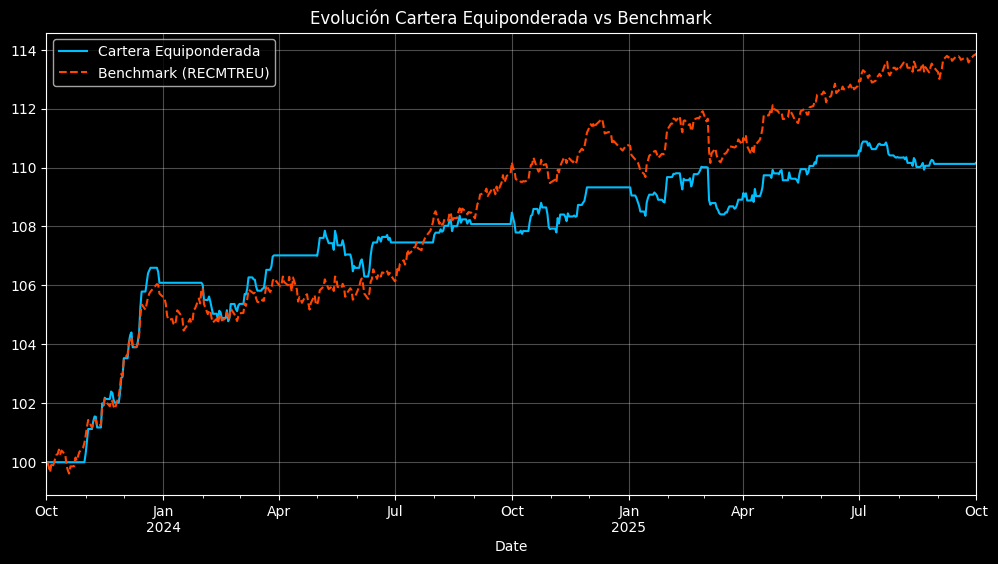

In [ ]:
# fechas de rebalanceo 
dates = prices_universe_df.index.sort_values()
monthly_dates = dates.to_series().resample('ME').last().dropna()
portfolio_series = pd.Series(index=dates, dtype=float)
portfolio_series.iloc[0] = 100.0 # Base 100
capital = 100.0

# Bucle de simulación diaria
current_bonds = prices_universe_df.loc[dates[0]].dropna().index.tolist()

for i in range(1, len(dates)):
    prev_date = dates[i-1]
    date = dates[i]
    
    # REBALANCEO: Si el día anterior fue fin de mes, actualizamos la lista de bonos
    if prev_date in monthly_dates.values:
        # Seleccionamos bonos que tengan precio hoy (vivos y cotizando)
        current_bonds = prices_universe_df.loc[prev_date].dropna().index.tolist()
    
    if not current_bonds:
        period_return = 0.0
    else:
        # Calculamos rentabilidad diaria promedio de los bonos seleccionados
        p_curr = prices_universe_df.loc[date, current_bonds]
        p_prev = prices_universe_df.loc[prev_date, current_bonds]
        rets = (p_curr - p_prev) / p_prev # Rentabilidad simple diaria: (P_t - P_t-1) / P_t-1
        rets = rets.fillna(0.0)
        period_return = rets.mean()#equiponderada
        
    # Actualizacion de capital
    capital = capital * (1 + period_return)
    portfolio_series.iloc[i] = capital

print(f"Valor Final Cartera: {capital:.2f}")
# Comparación con Benchmark (RECMTREU) normalizado a 100
benchmark = prices_various_df['RECMTREU Index'].dropna()
benchmark = benchmark / benchmark.iloc[0] * 100.0

plt.figure(figsize=(12, 6))
portfolio_series.plot(label='Cartera Equiponderada', color='#00BFFF')
benchmark.plot(label='Benchmark (RECMTREU)', color='#FF4500', linestyle='--')
plt.title('Evolución Cartera Equiponderada vs Benchmark')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Explicación del Algoritmo de Inversión (Cartera Equiponderada)

El algoritmo simula el comportamiento histórico de una estrategia de inversión pasiva con rebalanceo mensual. Los pasos realizados son:

1.  **Definición del Calendario:**
    *   Se identifican todas las fechas disponibles en el histórico de precios.
    *   Se determinan las fechas de **rebalanceo**, que corresponden al último día hábil de cada mes (`resample('ME')`).

2.  **Inicialización:**
    *   Se parte de un capital base de **100**.
    *   El primer día, se invierte en **todos los bonos vivos** (aquellos que tienen precio cotizado) asignando el mismo peso a cada uno ($1/N$).

3.  **Simulación Diaria (Bucle):**
    *   Se recorre día a día el histórico.
    *   **Cálculo de Rentabilidad:** Cada día se calcula la rentabilidad promedio de los bonos que componen la cartera en ese momento. Al ser equiponderada, la rentabilidad de la cartera es simplemente la media aritmética de las rentabilidades individuales de los bonos activos.
    *   **Actualización del Capital:** El valor de la cartera se actualiza diariamente acumulando dicha rentabilidad ($Valor_t = Valor_{t-1} \times (1 + Rentabilidad_t)$).

4.  **Rebalanceo Mensual:**
    *   Si el día anterior fue fin de mes, se ejecuta el rebalanceo: se actualiza la lista de bonos elegibles (`current_bonds`).
    *   Esto implica vender los bonos que hayan vencido o dejado de cotizar y comprar los nuevos que hayan entrado en el universo, volviendo a asignar pesos iguales a todos.

5.  **Comparación con Benchmark:**
    *   Finalmente, se compara la evolución de nuestra cartera simulada con el índice de referencia **RECMTREU** (normalizado también a base 100) para evaluar el desempeño relativo.

**P: ¿Qué sería lo más correcto en lugar de utilizar los precios MID?**

R:Lo más correcto sería utilizar precios **BID** (para valorar la venta de bonos) y precios **ASK** (para valorar la compra), o al menos tener en cuenta el **Bid-Ask Spread** como un coste de transacción explícito.
Usar precios MID (punto medio) subestima los costes de rebalanceo y sobreestima la rentabilidad neta, especialmente en mercados de renta fija corporativa donde las horquillas pueden ser amplias.




**P:¿Se te ocurre algún otro benchmark que se podría utilizar?**

R: Además del índice RECMTREU (que es un índice general de crédito euro), podríamos usar:
1.  **ETFs de Bonos Corporativos Euro:** Como el *iShares Euro Corp Bond Large Cap UCITS ETF*, que es replicable y tiene costes reales.
2.  **Índices más específicos:** Si nuestra cartera tiene sesgo a un sector (ej. Financiero) o rating (ej. BBB), deberíamos usar un sub-índice que refleje ese universo (ej. *Bloomberg Euro Aggregate Corporate BBB Index*).



### <font color=#336699>6. Cartera mandato</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Como adelantábamos en el enunciado, tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
- La duración de la cartera no debe superar los 3 años
- La exposición a emisiones HY no puede superar el 10% de la cartera
- No puedes invertir en deuda subordinada
- No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
- No se puede invertir más de un 10% del capital en una misma emisión
- No puede haber más de un 15% de concentración en un mismo emisor
(¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

1. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

2. ¿Cómo medirías el riesgo de crédito de la cartera?

3. ¿Cómo medirías el riesgo de liquidez de la cartera? ¿Se te ocurre alguna otra información que se podría utilizar aunque no se te haya dado?

4. Describe cómo habría que hacer el backtest de esta cartera, no hace falta que lo implementes en este caso

</div>

In [ ]:
ig_ratings = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-']
candidates = []


for idx, row in universe_df.iterrows():
    # Restricción: Tamaño > 500M
    if pd.isna(row['Outstanding Amount']) or row['Outstanding Amount'] <= 500_000_000: continue
    
    # Restricción: No Subordinada
    if 'sub' in str(row['Seniority']).lower(): continue
    
    # Datos necesarios
    price = row['Price']
    if pd.isna(price): continue
    
    # Calculamos métricas para el candidato
    # Usamos spread=0 para valoración teórica, pero para la selección nos interesa el Yield real de mercado
    _, ai, _ = calculate_bond_price(row, curve_df, FECHA_ANALISIS, spread=0.0)
    market_dirty = price + ai
    ytm = calculate_yield(row, FECHA_ANALISIS, market_dirty)
    
    if pd.isna(ytm): continue
    
    dur, _ = calculate_duration_convexity(row, FECHA_ANALISIS, ytm)
    if pd.isna(dur): continue
    
    is_hy = row['Rating'] not in ig_ratings
    
    candidates.append({
        'ISIN': row['ISIN'],
        'Issuer': row['Issuer'],
        'Rating': row['Rating'],
        'Yield': ytm,
        'Duration': dur,
        'Is_HY': is_hy,
        'Price': price,
        'Outstanding': row['Outstanding Amount']
    })

candidates_df = pd.DataFrame(candidates).sort_values('Yield', ascending=False)
print(f"Candidatos elegibles: {len(candidates_df)}")

#Algoritmo de Selección (Greedy con Restricciones)
final_portfolio = []
hy_candidates = candidates_df[candidates_df['Is_HY']]
ig_candidates = candidates_df[~candidates_df['Is_HY']]

def check_constraints(portfolio, new_bond):
    # Restricción: Max 3 bonos por emisor
    if sum(1 for b in portfolio if b['Issuer'] == new_bond['Issuer']) >= 3: return False
    return True

# Seleccionar los 2 mejores bonos HY (Max 10% de 20 bonos)
for _, bond_series in hy_candidates.iterrows():
    bond = bond_series.to_dict()
    if len([b for b in final_portfolio if b['Is_HY']]) >= 2: break
    if check_constraints(final_portfolio, bond): final_portfolio.append(bond)

# Rellenar hasta 20 con los mejores bonos IG
needed = 20 - len(final_portfolio)
for _, bond_series in ig_candidates.iterrows():
    bond = bond_series.to_dict()
    if len(final_portfolio) >= 20: break
    if check_constraints(final_portfolio, bond): final_portfolio.append(bond)

# Optimización de Duración (si nos pasamos de 3 años)
# Si la duración media > 3, cambiamos bonos de larga duración por corta duración (sacrificando el menor yield posible)
current_dur = sum(b['Duration'] for b in final_portfolio) / len(final_portfolio)

if current_dur > 3.0:
    print(f"\n--- INICIANDO OPTIMIZACIÓN ---")
    print(f"Duración inicial: {current_dur:.2f} años (Objetivo: < 3.0)")
    
    # Crear pool de candidatos IG que NO están en la cartera y tienen duración BAJA (< 3)
    # Esto es clave: solo nos interesa intercambiar por bonos cortos para bajar el promedio
    current_ids = [b['ISIN'] for b in final_portfolio]
    short_duration_pool = [
        b.to_dict() for _, b in ig_candidates.iterrows() 
        if b['ISIN'] not in current_ids and b['Duration'] < 3.0
    ]
    
    print(f"Candidatos disponibles para reducir duración: {len(short_duration_pool)}")
    
    max_iter = 100
    for i in range(max_iter):
        current_dur = sum(b['Duration'] for b in final_portfolio) / len(final_portfolio)
        if current_dur <= 3.0:
            print(f" Duración actual: {current_dur:.2f}")
            break
            
        # Estrategia: Quitar el bono con MAYOR duración de la cartera
        # y sustituirlo por el bono del pool que tenga MAYOR Yield (para perder lo mínimo)
        
        # Identificar bono a salir (el de mayor duración)
        bond_out = max(final_portfolio, key=lambda x: x['Duration'])
        
        # Identificar mejor candidato a entrar (Yield más alto posible, respetando constraints)
        best_in = None
        best_in_yield = -1.0
        
        # Ordenamos el pool por Yield descendente para encontrar el mejor rápido
        short_duration_pool.sort(key=lambda x: x['Yield'], reverse=True)
        
        for candidate in short_duration_pool:
            # Verificar restricciones de emisor si hiciéramos el cambio
            temp_portfolio = [b for b in final_portfolio if b['ISIN'] != bond_out['ISIN']]
            
            if check_constraints(temp_portfolio, candidate):
                best_in = candidate
                break # Como ordenamos por Yield, el primero que cumpla es el mejor
        
        if best_in:
            # Ejecutar Swap
            final_portfolio.remove(bond_out)
            final_portfolio.append(best_in)
            
            # Actualizar pool (el que sale entra al pool, el que entra sale del pool)
            short_duration_pool.remove(best_in)
            if bond_out['Duration'] < 3.0: # Solo si sirve para bajar duración en el futuro
                short_duration_pool.append(bond_out)
                
            print(f"Iter {i+1}: Sale {bond_out['ISIN']} (Dur: {bond_out['Duration']:.2f}) -> Entra {best_in['ISIN']} (Dur: {best_in['Duration']:.2f}). Nueva Duración Cartera: {sum(b['Duration'] for b in final_portfolio)/20:.2f}")
        else:
            print("No se encontraron más candidatos válidos para intercambiar.")
            break

final_df = pd.DataFrame(final_portfolio)
avg_dur = final_df['Duration'].mean()
avg_yield = final_df['Yield'].mean()
hy_exposure = final_df['Is_HY'].sum() / len(final_df)

print("\n--- Cartera Final Construida ---")

print(final_df[['ISIN', 'Issuer', 'Rating', 'Yield', 'Duration']].to_string())

print(f"\nDuración Media: {avg_dur:.2f} años (Max 3.0)")
print(f"Yield Medio: {avg_yield:.2%} (Maximizado)")
print(f"Exposición HY: {hy_exposure:.0%} (Max 10%)")
print(f"Total Bonos: {len(final_df)}")

Candidatos elegibles: 1353

--- INICIANDO OPTIMIZACIÓN ---
Duración inicial: 12.74 años (Objetivo: < 3.0)
Candidatos disponibles para reducir duración: 529
Iter 1: Sale XS2386220698 (Dur: 23.95) -> Entra FR0013231768 (Dur: 1.02). Nueva Duración Cartera: 11.59
Iter 2: Sale DE000A3MP4W5 (Dur: 19.05) -> Entra XS2397252102 (Dur: 2.25). Nueva Duración Cartera: 10.75
Iter 3: Sale XS2238792688 (Dur: 18.67) -> Entra XS1492458044 (Dur: 2.80). Nueva Duración Cartera: 9.96
Iter 4: Sale XS2366415540 (Dur: 18.42) -> Entra XS2384274366 (Dur: 2.66). Nueva Duración Cartera: 9.17
Iter 5: Sale XS2051149552 (Dur: 17.82) -> Entra XS2384715244 (Dur: 1.78). Nueva Duración Cartera: 8.37
Iter 6: Sale XS2058557344 (Dur: 17.66) -> Entra XS2393323071 (Dur: 2.82). Nueva Duración Cartera: 7.63
Iter 7: Sale XS2020671157 (Dur: 17.66) -> Entra XS2489775580 (Dur: 2.84). Nueva Duración Cartera: 6.89
Iter 8: Sale XS2375844656 (Dur: 13.46) -> Entra XS2225207468 (Dur: 1.16). Nueva Duración Cartera: 6.27
Iter 9: Sale XS262

Posiblemente no salga toda la cartera por la configuracion del notebook, debe de dar una opcion de verlo en una ventana aparte (probado en vs code)

##### <font color=#CC6600>Más restricciones</font>

Sí, para robustecer la cartera añadiríamos:
1.  **Diversificación Sectorial:** Limitar la exposición a un solo sector (ej. Financiero o Industrial) al 20-25% para evitar riesgos sistémicos específicos.
2.  **Diversificación Geográfica:** Poner un tope por país (ej. máx 20% en emisores de un mismo país) para mitigar el riesgo soberano.
3.  **Rating Mínimo Medio:** Exigir que el rating promedio ponderado sea al menos BBB+, para asegurar que la búsqueda de yield no degrade excesivamente la calidad crediticia global, aunque cumplamos el límite de HY.

##### <font color=#CC6600>Riesgo de crédito</font>

Una combinación de métricas:
1.  **DTS (Duration Times Spread):** Es la medida estándar de riesgo de mercado de crédito. Indica cuánto perdería la cartera si los spreads se ampliaran un 1% relativo. Es superior a la duración simple porque pondera más los bonos con mayor riesgo (mayor spread).
2.  **Rating Promedio Ponderado (WAR):** Asignando un valor numérico a cada rating (AAA=1, AA+=2...) para monitorizar la calidad media.
3.  **Probabilidad de Default (PD) 1Y:** Calcular la PD ponderada de la cartera usando los datos provistos en el fichero, lo que nos da una estimación directa de la pérdida esperada por impago en el próximo año.

##### <font color=#CC6600>Riesgo de liquidez</font>

1.  **Bid-Ask Spread Medio:** Calcular el diferencial medio entre precio de compra y venta de los bonos en cartera. A mayor spread, menor liquidez y mayor coste de deshacer posiciones.
2.  **Tiempo de Liquidación (Days to Liquidate):** Estimar cuántos días tardaríamos en vender la posición completa de cada bono sin impactar el precio, basándonos en el volumen diario medio de negociación (si tuviéramos ese dato).
3.  **LCS (Liquidity Cost Score):** Una métrica estandarizada que refleja el coste de ida y vuelta de una operación.

##### <font color=#CC6600>Backtest</font>

1.  **Bid-Ask Spread Medio:** Calcular el diferencial medio entre precio de compra y venta de los bonos en cartera. A mayor spread, menor liquidez y mayor coste de deshacer posiciones.
2.  **Tiempo de Liquidación (Days to Liquidate):** Estimar cuántos días tardaríamos en vender la posición completa de cada bono sin impactar el precio, basándonos en el volumen diario medio de negociación (si tuviéramos ese dato).
3.  **LCS (Liquidity Cost Score):** Una métrica estandarizada que refleja el coste de ida y vuelta de una operación.

### <font color=#336699>7. Cobertura tipos de interés</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir la duración (sensibilidad de tipos de interés) de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- Futuros sobre el *Schatz* (ticker: DU1) - Duración a 01/10/2025: 1.92
- Futuros sobre el *BOBL* (ticker: OE1) - Duración a 01/10/2025: 5.44
- Futuros sobre el *BUND* (ticker: RX1) - Duración a 01/10/2025: 10

*Contract size* en todos los casos: 100,000 euros

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el número de contratos que has decidido comprar/vender.

- ¿Qué pasaría si comprásemos/vendiésemos 100 futuros?
- ¿Se te ocurre algún otro instrumento con el que cubrir la sensibilidad a los tipos de interés de la cartera?

</div>

In [ ]:
portfolio_value = 10000000  # 10 Millones de euros
portfolio_duration = avg_dur  # Duración de nuestra cartera mandato (aprox 3.0)

# Datos de los Futuros (a 01/10/2025)
futures_data = {
    'Schatz (2Y)': {'Duration': 1.92, 'Ticker': 'DU1'},
    'Bobl (5Y)':   {'Duration': 5.44, 'Ticker': 'OE1'},
    'Bund (10Y)':  {'Duration': 10.0, 'Ticker': 'RX1'}
}
contract_size = 100_000

# Vamos a calcularlo con el BOBL (OE1) como ejemplo principal, pero mostramos todos.

print(f" Cálculo de Cobertura (Cartera {portfolio_value:,.0f}€, Duración {portfolio_duration:.2f})")

# Fórmula: BPV Cartera = BPV Futuro * N_Contratos
# BPV (Basis Point Value) ~= Valor * Duración * 0.0001
# N_Contratos = (Valor_Cartera * Dur_Cartera) / (Valor_Nominal_Futuro * Dur_Futuro)

for name, data in futures_data.items():
    future_dur = data['Duration']
    
    # Ratio de Cobertura = (Valor Cartera * Duración Cartera) / (Tamaño Contrato * Duración Futuro)
    # VENDER futuros para reducir duración (tener duración negativa).
    n_contracts = (portfolio_value * portfolio_duration) / (contract_size * future_dur)
    
    print(f"\nInstrumento: {name} (Dur: {future_dur})")
    print(f"Contratos a VENDER: {n_contracts:.2f} -> {round(n_contracts)} contratos")

# Elección Final
chosen_instrument = 'Bobl (5Y)'
chosen_contracts = round((portfolio_value * portfolio_duration) / (contract_size * futures_data[chosen_instrument]['Duration']))

print(f"\nDECISIÓN FINAL: Vender {chosen_contracts} contratos de {chosen_instrument}")

 Cálculo de Cobertura (Cartera 10,000,000€, Duración 2.94)

Instrumento: Schatz (2Y) (Dur: 1.92)
Contratos a VENDER: 152.93 -> 153 contratos

Instrumento: Bobl (5Y) (Dur: 5.44)
Contratos a VENDER: 53.98 -> 54 contratos

Instrumento: Bund (10Y) (Dur: 10.0)
Contratos a VENDER: 29.36 -> 29 contratos

DECISIÓN FINAL: Vender 54 contratos de Bobl (5Y)


**P:Razona tu elección del instrumento y el número de contratos:**


R:
**Elección del Instrumento:**
Hemos elegido los futuros sobre el **BOBL (5 años)** porque es el punto de la curva más cercano a la duración media de nuestra cartera (~3 años).
*   Usar el *Bund* (10 años) introduciría un "riesgo de curva" (twist risk): si la curva se mueve de forma no paralela (ej. suben los tipos cortos pero no los largos), la cobertura no funcionaría bien.
*   El *Schatz* (2 años) también sería una opción válida dada la corta duración de la cartera.

**Número de contratos:**
Hemos decidido **VENDER** contratos (posición corta).
*   La cartera tiene duración positiva (pierde valor si suben tipos).
*   Para cubrirnos, necesitamos un instrumento que gane valor si suben tipos (o vender uno que pierda). Al vender futuros, ganamos si el precio del bono baja (tipos suben), compensando la pérdida de la cartera.
*   El número exacto iguala el BPV (Basis Point Value) de la cartera con el del futuro.

### <font color=#336699>8. Cobertura crédito</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir el riesgo de crédito de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- ITRAXX Main (ticker: ITRX EUR CDSI GEN 5Y Corp)
- ITRAXX XOVER (ticker: ITRX XOVER CDSI GEN 5Y Corp)

Estos índices cotizan en forma de spread, en puntos básicos. La sensibilidad del valor del swap (CDS) la vamos a asumir en 4,500€ al punto básico asumiendo una inversión de 10 millones.

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el nominal que has decidido comprar/vender.

- ¿Tiene sentido plantear esta cobertura total?
- ¿Con qué otros instrumentos podrías cubrir el riesgo de crédito?

</div>

In [ ]:

# Datos
portfolio_value = 10000000
# Dado que nuestra cartera es mayoritariamente Investment Grade (IG), el índice adecuado es el iTraxx Main.

# Instrumentos disponibles (precios en bps o puntos)
itraxx_main_price = prices_various_df['ITRX EUR CDSI GEN 5Y Corp'].iloc[-1] # Último precio disponible
itraxx_xover_price = prices_various_df['ITRX XOVER CDSI GEN 5Y Corp'].iloc[-1]

print(f" Cobertura de Crédito con CDS ")
print(f"Precio iTraxx Main (IG): {itraxx_main_price:.2f} bps")
print(f"Precio iTraxx Crossover (HY): {itraxx_xover_price:.2f} bps")

# Mandato de máx 10% HY. Por tanto, es una cartera fundamentalmente IG. El instrumento más correlacionado es el iTraxx Europe Main.
instrumento_cobertura = "iTraxx Europe Main 5Y"

# Cálculo del Nominal a Comprar. En una cobertura simple (naive), compramos protección por el mismo valor nominal que la cartera.
# Nominal Cobertura = Valor Cartera * Beta. Asumiendo Beta = 1 (correlación perfecta y misma volatilidad de spreads)
nominal_cobertura = portfolio_value

print(f"\nEstrategia Seleccionada: Comprar protección (CDS) sobre {instrumento_cobertura}")
print(f"Nominal a cubrir: {nominal_cobertura:,.0f} €")

# Coste de la cobertura (anual)
# Coste = Nominal * Spread (en tanto por uno)
coste_anual = nominal_cobertura * (itraxx_main_price / 10000)
print(f"Coste anual estimado de la cobertura (prima): {coste_anual:,.2f} €")

 Cobertura de Crédito con CDS 
Precio iTraxx Main (IG): 55.33 bps
Precio iTraxx Crossover (HY): 260.63 bps

Estrategia Seleccionada: Comprar protección (CDS) sobre iTraxx Europe Main 5Y
Nominal a cubrir: 10,000,000 €
Coste anual estimado de la cobertura (prima): 55,333.18 €


**P:¿Qué instrumento utilizarías? ¿Por qué?**

R: Utilizaría el **iTraxx Europe Main 5Y**.
*   **Razón:** Nuestra cartera es predominantemente *Investment Grade* (mínimo 90% por mandato). El índice iTraxx Main está compuesto por 125 entidades europeas con grado de inversión, por lo que es el proxy más fiel al riesgo de nuestra cartera.
*   El *iTraxx Crossover* (Xover) cubre bonos *High Yield* (sub-investment grade). Usarlo sería ineficiente (basis risk muy alto) y mucho más caro, ya que estaríamos pagando por cubrir un riesgo de impago mucho más alto del que realmente tiene nuestra cartera.

**P:¿Qué posición tomarías: compradora o vendedora de protección?**

R:Tomaría una posición **COMPRADORA de protección** (Buy Protection).
*   En el mercado de CDS, "comprar protección" significa pagar una prima periódica a cambio de recibir una compensación si ocurre un evento de crédito (impago) en las entidades del índice.
*   Es análogo a comprar un seguro de coche: pagas la prima para estar cubierto si tienes un accidente.

**P:¿Qué nominal cubrirías?**

R:Cubriría un nominal de **10.000.000 €** (el valor total de la cartera).
*   Esto asume una "Beta" de 1, es decir, que los spreads de mi cartera se mueven igual que los del índice.
*   Si quisiéramos ser más precisos, calcularíamos la Beta de la cartera respecto al índice (sensibilidad relativa). Si nuestra cartera fuera más arriesgada que el índice (Beta > 1), necesitaríamos comprar *más* nominal. Si fuera más segura (Beta < 1), *menos*. Pero ante la falta de datos históricos largos de nuestra cartera sintética, la cobertura 1:1 es el estándar prudente.

### <font color=#336699>9. Estrategia propia</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Plantea tu propia estrategia con la información que tienes. Puede ser una estrategia direccional, de valor relativo, que hayas visto o no en clase; pero siempre razonando tu planteamiento.

</div>

### <font color=#336699>10. FUTURAS MEJORAS </font>

Para profesionalizar aún más esta herramienta y profundizar en el análisis de la cartera, se proponen las siguientes líneas de mejora:

### 1. Refinamiento de la Valoración
*   **Curva de Tipos (Bootstrapping):** Implementar un método de *bootstrapping* completo para construir la curva cupón cero (Zero Curve) a partir de instrumentos de mercado (Depósitos, FRAs, Swaps) en lugar de utilizar una interpolación lineal simple de la curva ESTR.
*   **Modelos para Bonos con Opciones:** Utilizar árboles binomiales o modelos como *Black-Derman-Toy* para valorar con mayor precisión los bonos *callable* y *puttable*, calculando su *OAS (Option Adjusted Spread)* y *Duración Efectiva*.

### 2. Métricas de Riesgo Avanzadas
*   **Key Rate Durations (KRD):** Calcular la sensibilidad de la cartera a movimientos no paralelos de la curva de tipos (ej. si suben los tipos a corto pero bajan a largo).
*   **Value at Risk (VaR) y Expected Shortfall:** Implementar métricas estadísticas (VaR Histórico o Paramétrico) para cuantificar la pérdida máxima esperada con un nivel de confianza del 95% o 99%.
*   **Stress Testing:** Simular escenarios macroeconómicos adversos (ej. ampliación masiva de spreads de crédito o shock de tipos) para ver el impacto en el P&L de la cartera.

### 3. Optimización de Cartera
*   **Algoritmos de Optimización:** Sustituir la selección heurística ("greedy") por optimizadores matemáticos (Programación Cuadrática o Lineal) que maximicen el Yield o el Ratio de Sharpe sujetos a múltiples restricciones simultáneas.
*   **Costes de Transacción:** Incorporar el *Bid-Ask Spread* y comisiones en las simulaciones de rebalanceo para obtener un retorno neto más realista.

### 4. Tecnología y Datos
*   **Automatización de Datos:** Conectar la herramienta a una API de mercado (Bloomberg, Refinitiv o Yahoo Finance) para actualizar precios y curvas en tiempo real.
*   **Dashboard Interactivo:** Crear una interfaz gráfica (usando librerías como *Streamlit* o *Dash*) que permita a un gestor visualizar la exposición de la cartera y ejecutar rebalanceos de forma intuitiva.